In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from operator import itemgetter
import random
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("10ClusterCampaign.json")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
print(scores[0])
print(positive[0])
print(negative[0])
print(neut[0])


0.7494
0.285
0.0
0.715


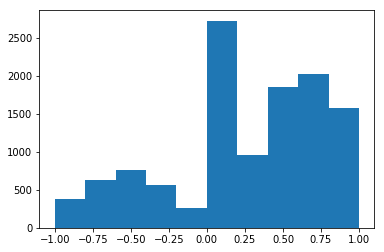

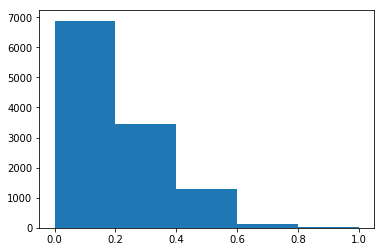

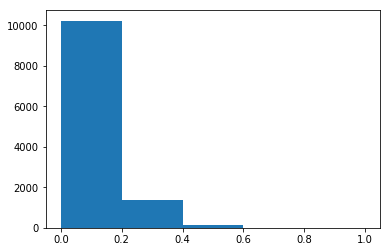

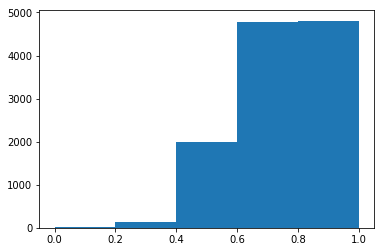

In [3]:
plt.hist(scores,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(positive,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(negative,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(neut,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

In [4]:
data["vaderScore"] = scores
data.drop(["in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","year","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,month,hour,week_year,labels,vaderScore
favorite_count,1.000000,0.929920,0.250773,0.060894,0.239500,0.003888,-0.063807
retweet_count,0.929920,1.000000,0.242095,0.066795,0.231188,0.006894,-0.087421
month,0.250773,0.242095,1.000000,0.071850,0.976724,-0.018228,-0.043811
hour,0.060894,0.066795,0.071850,1.000000,0.072169,0.025396,-0.042753
week_year,0.239500,0.231188,0.976724,0.072169,1.000000,-0.015554,-0.043288
labels,0.003888,0.006894,-0.018228,0.025396,-0.015554,1.000000,-0.119046
vaderScore,-0.063807,-0.087421,-0.043811,-0.042753,-0.043288,-0.119046,1.000000


0.23019075730471084


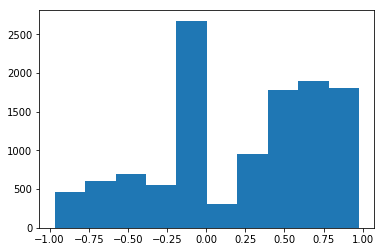

In [5]:
plt.hist(data["vaderScore"])
print(data["vaderScore"].mean())

In [14]:
x1 = data[data["labels"] == 5]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  

stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

605


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.875e+03, 6.900e+01, 2.000e+01, 9.000e+00, 6.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   4. ,  168.8,  333.6,  498.4,  663.2,  828. ,  992.8, 1157.6,
        1322.4, 1487.2, 1652. ]),
 <a list of 10 Patch objects>)

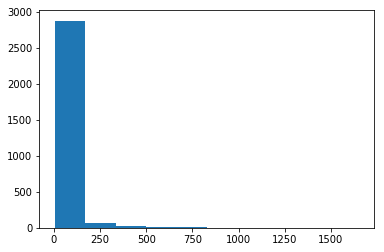

In [15]:
plt.hist(stemmed_words)

In [16]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!!
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
res

,favorite_count,retweet_count,month,hour,week_year,noTags_punct,modded1_stemmed,labels,vaderScore,m,...,yet,york,yorker,youll,young,your,youv,zero,zogbi,zone
0,33,9,1,7,1,sparkleawin realdonaldtrump so excited for a n...,sparkleawin realdonaldtrump excit new yea...,5,0.5068,excit new year amp new celeb apprentic cant wa...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,23,8,1,21,1,sean icahnkravisbuffet amp many other top busi...,sean icahnkravisbuffet amp mani top busi...,5,0.4215,sean amp mani top busi taken advantag corpor b...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,20,5,1,3,2,mari907 realdonaldtrump amp ivankatrump back o...,mari907 realdonaldtrump amp ivankatrump b...,5,0.6114,amp ivankatrump back tv im happi,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,71,25,1,22,2,brandiglanville tonight celebrity apprentice 8...,brandiglanvil tonight celebr apprentic 87...,5,0.0000,brandiglanvil tonight celebr apprentic 2 amp 3...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,13,10,1,3,2,tborio ivankatrump realdonaldtrump she truly...,tborio ivankatrump realdonaldtrump truli ...,5,0.6124,ivankatrump truli amp well spoken amp graciou,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
5,74,20,1,3,2,srt_sully realdonaldtrump geraldo is an egotis...,srt_sulli realdonaldtrump geraldo egotist ...,5,0.3164,geraldo strong competitor amp make good show,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
6,165,58,1,20,2,thanks to our loyal viewers amp fans last nigh...,thank loyal viewer amp fan last night ...,5,0.7184,thank loyal viewer amp fan last night apprenti...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
7,213,142,1,21,2,congress must repeal obamacare obama will veto...,congress must repeal obamacar obama veto...,5,-0.4767,congress must repeal obamacar obama american c...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
8,20,9,1,6,2,erniefan4life realdonaldtrump right on man run...,erniefan4lif realdonaldtrump right man ru...,5,0.0000,right man run presid amp fix,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
9,19,20,1,13,2,insidesouthfl photo amp donaldtrump 1 show ...,insidesouthfl photo amp donaldtrump 1 sh...,5,0.0000,photo amp donaldtrump 1 show nbc 1 golf cours ...,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [17]:
res1.columns

Index(['week_year', 'vaderScore', '10', '100', '1000', '10pm', '11', '118',
       '1182016', '12',
       ...
       'yet', 'york', 'yorker', 'youll', 'young', 'your', 'youv', 'zero',
       'zogbi', 'zone'],
      dtype='object', length=1716)

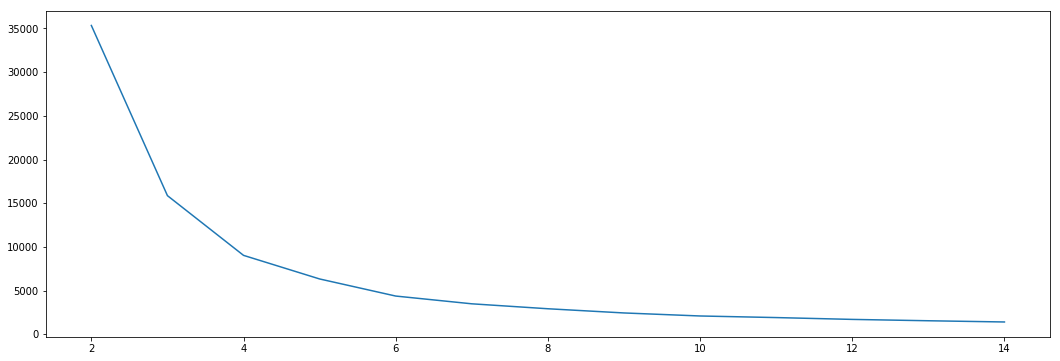

CPU times: user 44.4 s, sys: 1min 33s, total: 2min 18s
Wall time: 6.05 s


In [18]:
%%time
sse_list = list()
max_k = 15
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()

In [19]:
#6 per il label 1 (15 cluster)
#monthe vader alzano la silhouette

#per label 2 week year peggiora sse ma aumenta silhouette
#solo vader e tfidf abbassano di un botto l'sse per label 2


#sembra che usare week year peggiori l'sse ma aumenti di molto la silhouette. Come interpretare? cosa preferire?
true_k =6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

4366.273969242905
0.5657803010406125


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [20]:
#per descrivere i cluster prendi i valori con tfidf più alto
g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    meanTf = []
    for column in g1.columns:
        if column != "labels":
            m = g1[column].mean()
            meanTf.append([column,m])
    
    meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    el = random.randint(g1.index[0],g1.index[len(g1)-1])
    el1 = random.randint(g1.index[0],g1.index[len(g1)-1])
    el2 = random.randint(g1.index[0],g1.index[len(g1)-1])
    #print(res.iloc[el]["noTags_punct"] + "\n")
    #print(res.iloc[el1]["noTags_punct"]+ "\n")
    #print(res.iloc[el2]["noTags_punct"]+ "\n")
    
    tokenizer = RegexpTokenizer(r'\w+')

    counted = pd.Series(' '.join(d1['m']).split()).value_counts()
    #counted = counted[5:] #5 per label 1 
    counted = counted[counted > 5]
    d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

    corpus = d1["m"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(string)
        corp.append(tokens)

    dictionary = corpora.Dictionary(corp)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
    
    start,stop,step=1,10,1
    nTopics = plot_graph(corp,start,stop,step)
    print("NUMBER OF TOPICS: ", nTopics)
    words = 7
    lsamodel = LsiModel(doc_term_matrix, num_topics=nTopics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = -1,num_words = words))

cluster  3  lunghezza  105 :
 [['week_year', 4.828571428571428], ['amp', 0.06982352967793133], ['great', 0.030058492991625007], ['make', 0.024743861871220484], ['america', 0.022880576188617933]]



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


NUMBER OF TOPICS:  2
[(0, '0.961*"amp" + 0.137*"great" + 0.095*"thank" + 0.086*"make" + 0.084*"america" + 0.062*"cruz" + 0.056*"show"'), (1, '0.626*"great" + 0.477*"make" + 0.459*"america" + 0.190*"trump2016" + 0.161*"thank" + -0.158*"amp" + -0.154*"cruz"')]
cluster  0  lunghezza  98 :
 [['week_year', 13.60204081632653], ['amp', 0.06460745209252751], ['run', 0.021972039340408443], ['pleas', 0.021327609677260797], ['need', 0.02050205471161043]]

NUMBER OF TOPICS:  1
[(0, '0.965*"amp" + 0.086*"america" + 0.082*"great" + 0.082*"need" + 0.077*"border" + 0.076*"run" + 0.073*"time"')]
cluster  5  lunghezza  110 :
 [['week_year', 21.69090909090909], ['amp', 0.07225034819758604], ['make', 0.02774757369492268], ['run', 0.027432219116281874], ['great', 0.02641721736838559]]

NUMBER OF TOPICS:  9
[(0, '0.960*"amp" + 0.093*"make" + 0.089*"run" + 0.087*"thank" + 0.085*"great" + 0.078*"get" + 0.063*"deal"'), (1, '-0.643*"make" + -0.571*"great" + -0.433*"america" + 0.141*"amp" + -0.106*"time" + -0.09

In [13]:
stemmed_words

great                    1652
thank                    1381
amp                       905
america                   803
make                      772
trump2016                 768
presid                    763
donald                    755
get                       671
hillari                   634
peopl                     617
vote                      593
run                       588
go                        584
makeamericagreatagain     548
need                      533
new                       531
poll                      525
time                      477
watch                     469
would                     469
like                      468
love                      454
countri                   452
us                        419
one                       402
show                      379
win                       379
clinton                   378
want                      378
                         ... 
caesar                      4
modern                      4
500       

In [ ]:
dictionary = corpora.Dictionary(corp)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
doc_term_matrix